In [1]:
import os

import numpy as np 
import pandas as pd 

from sklearn.utils import resample # équilibrage de classes

# Préparation des données pour entrainement
from sklearn.model_selection import train_test_split

# Paramètres du modèle
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# sauvegarde des hyperparamètres
import pickle

# Explicabilité
import shap

In [10]:
# Training set A
# Chemin vers le dossier contenant les fichiers .psv
folder_path = r'C:\Users\AdminPC\OneDrive\Desktop\stage\mimic_III\training_setA\training'
files = os.listdir(folder_path)

# Créer un DataFrame pour tous les patients
df_list = []
for file in files:
    if file.endswith('.psv'):
        path = os.path.join(folder_path, file)
        patient_df = pd.read_csv(path, delimiter='|')
        patient_df['Patient_ID'] = file.split('.')[0][1:]  # Assumer que le nom du fichier sans 'p' est l'ID du patient
        df_list.append(patient_df)

training_setA = pd.concat(df_list, ignore_index=True)
training_setA['Hour'] = training_setA.groupby('Patient_ID').cumcount()  # Ajouter un compteur temporel pour chaque patient

# Training set B
# Chemin vers le dossier contenant les fichiers .psv
folder_path = r"C:\Users\AdminPC\OneDrive\Desktop\stage\mimic_III\training_setB\training_setB"
files = os.listdir(folder_path)

# Créer un DataFrame pour tous les patients
df_list = []
for file in files:
    if file.endswith('.psv'):
        path = os.path.join(folder_path, file)
        patient_df = pd.read_csv(path, delimiter='|')
        patient_df['Patient_ID'] = file.split('.')[0][1:]  # Assumer que le nom du fichier sans 'p' est l'ID du patient
        df_list.append(patient_df)

training_setB = pd.concat(df_list, ignore_index=True)
training_setB['Hour'] = training_setB.groupby('Patient_ID').cumcount()  # Ajouter un compteur temporel pour chaque patient

full_data = pd.concat([training_setA, training_setB], ignore_index=True)

In [4]:
point_data.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0


In [5]:
point_data.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [8]:
full_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,Time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,p000001,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,p000001,1
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,p000001,2
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,p000001,3
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,p000001,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,88.0,98.0,NaN,135.0,81.00,64.0,16.0,NaN,NaN,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,31,1,p020643,28
790211,96.0,98.0,38.72,174.0,97.00,72.0,16.0,NaN,2.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,32,1,p020643,29
790212,140.0,97.0,NaN,133.0,81.50,62.5,16.0,NaN,NaN,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,33,1,p020643,30
790213,120.0,96.0,NaN,154.0,118.00,105.0,16.0,NaN,NaN,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,34,1,p020643,31


In [13]:
# Réordonner l'ordre des colonnes

# Colonnes à placer au début dans l'ordre spécifique
specified_columns = ['Patient_ID', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'Hour']

# Toutes les autres colonnes qui ne sont pas spécifiées
remaining_columns = [col for col in full_data.columns if col not in specified_columns]

# Nouvel ordre complet des colonnes
new_column_order = specified_columns + remaining_columns

full_data = full_data[new_column_order]

In [14]:
full_data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel
0,000001,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,000001,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,000001,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,000001,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,000001,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.00,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1552206,120000,62.00,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1552207,120000,62.00,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1552208,120000,62.00,0,0.00,34,33,82.0,99.0,36.6,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [15]:
full_data.shape

(1552210, 43)

In [23]:
# nombre de patient atteint du sepsis
lignes_with_sepsis_1['Patient_ID'].nunique()

2932

In [24]:
lignes_with_sepsis_1['Patient_ID'].value_counts()

Patient_ID
000009    10
019947    10
019847    10
019850    10
019866    10
          ..
118632     1
101933     1
113618     1
110426     1
117691     1
Name: count, Length: 2932, dtype: int64

In [25]:
# Décaler la colonne 'SepsisLabel' de 6 heures en avant pour la prédiction anticipée
timestamp_prediction = -6
full_data['SepsisLabel_Previous'] = full_data.groupby('Patient_ID')['SepsisLabel'].shift(timestamp_prediction)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\558644155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['SepsisLabel_Previous'] = full_data.groupby('Patient_ID')['SepsisLabel'].shift(timestamp_prediction)


In [32]:
# Remplacer les NaN par la dernière valeur connue dans 'SepsisLabel_Previous'
full_data['SepsisLabel_Previous'] = full_data.groupby('Patient_ID')['SepsisLabel_Previous'].fillna(method='ffill')

In [34]:
patient = full_data[full_data['Patient_ID'] == '000009']
patient[200:]

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
504,000009,27.92,1,-0.03,201,200,126.0,100.0,38.67,114.0,...,23.1,8.0,24.6,13.0,NaN,448.0,NaN,NaN,0,0.0
505,000009,27.92,1,-0.03,202,201,134.0,100.0,NaN,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
506,000009,27.92,1,-0.03,203,202,130.0,99.0,NaN,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
507,000009,27.92,1,-0.03,204,203,120.0,98.0,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
508,000009,27.92,1,-0.03,205,204,117.0,98.0,37.72,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
509,000009,27.92,1,-0.03,206,205,124.0,99.0,NaN,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
510,000009,27.92,1,-0.03,207,206,127.0,100.0,NaN,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
511,000009,27.92,1,-0.03,208,207,131.0,96.0,NaN,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
512,000009,27.92,1,-0.03,209,208,126.0,98.0,37.94,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
513,000009,27.92,1,-0.03,210,209,126.0,100.0,NaN,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


In [33]:
full_data[full_data['Patient_ID'] == '000001']

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,000001,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,000001,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,000001,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
3,000001,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,000001,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
5,000001,83.14,0,-0.03,6,5,110.0,91.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
6,000001,83.14,0,-0.03,7,6,108.0,92.0,36.11,123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
7,000001,83.14,0,-0.03,8,7,106.0,90.5,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
8,000001,83.14,0,-0.03,9,8,104.0,95.0,NaN,133.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
9,000001,83.14,0,-0.03,10,9,102.0,91.0,NaN,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


In [36]:
full_data['Unit1'].value_counts()

Unit1
0.0    473349
1.0    466901
Name: count, dtype: int64

In [38]:
lignes_with_sepsis_1 = full_data[full_data['SepsisLabel'] == 1]
print('nombre de lignes de patient atteint', lignes_with_sepsis_1.shape)


lignes_with_sepsis_0 = full_data[full_data['SepsisLabel'] == 0]
print('nombre de lignes de patient non atteint', lignes_with_sepsis_0.shape)


nombre de lignes de patient atteint (27916, 44)
nombre de lignes de patient non atteint (1524294, 44)


In [40]:
print('nombre de patients atteints', lignes_with_sepsis_1['Patient_ID'].nunique())
print('nombre de patients non atteints', lignes_with_sepsis_0['Patient_ID'].nunique())

nombre de patients atteints 2932
nombre de patients non atteints 39910


In [43]:
# Convertir la colonne 'SepsisLabel_Previous' en type int
full_data['SepsisLabel_Previous'] = full_data['SepsisLabel_Previous'].astype(int)


In [3]:
# full_data.to_csv('full_data_df.csv', index=False)

full_data = pd.read_csv('full_data_df.csv')
full_data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,1,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.00,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552206,120000,62.00,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552207,120000,62.00,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552208,120000,62.00,0,0.00,34,33,82.0,99.0,36.6,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [4]:
# get the list of patients who have sepsis before admission to ICU
admitted_with_sepsis_patients = full_data['Patient_ID'][(full_data['SepsisLabel']==1) & (full_data['Hour']==0)]
print(admitted_with_sepsis_patients.shape)

(426,)


In [5]:
# construct dataframe of patients who have sepsis before admission to ICU
admitted_with_sepsis_df = full_data[full_data.Patient_ID.isin(admitted_with_sepsis_patients)]
print(admitted_with_sepsis_df.shape)

(3646, 44)


In [51]:
# admitted_with_sepsis_df.to_csv('patient_admitted_with_sepsis.csv', index=False)


In [6]:
# Filtrer full_data pour exclure les patients présents dans admitted_with_sepsis_df
remaining_data = full_data[~full_data['Patient_ID'].isin(admitted_with_sepsis_patients)]
remaining_data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,1,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.00,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552206,120000,62.00,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552207,120000,62.00,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552208,120000,62.00,0,0.00,34,33,82.0,99.0,36.6,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [55]:
remaining_data[remaining_data['SepsisLabel'] == 1]['Patient_ID'].nunique()

2506

In [58]:
remaining_data.shape

(1548564, 44)

In [2]:
from sklearn.utils import shuffle

def balance_classes_by_missing_data(full_df, label_column='SepsisLabel_Previous', patient_id_column='Patient_ID', test_size=0.2, random_state=42):
    """
    Équilibre les classes en sous-échantillonnant la classe majoritaire basé sur la complétude des données,
    tout en préservant la temporalité des enregistrements pour chaque patient.
    
    Parameters:
    - full_df (pandas.DataFrame): DataFrame contenant les données des patients.
    - label_column (str): Nom de la colonne contenant les labels de classification.
    - patient_id_column (str): Nom de la colonne contenant les identifiants des patients.
    - test_size (float): Proportion de l'ensemble de test par rapport à l'ensemble total.
    - random_state (int): Graine pour la reproductibilité des résultats aléatoires.

    Returns:
    - X_train (pandas.DataFrame): Caractéristiques pour l'entraînement.
    - X_test (pandas.DataFrame): Caractéristiques pour le test.
    - y_train (pandas.Series): Labels pour l'entraînement.
    - y_test (pandas.Series): Labels pour le test.
    """
    # Calculer le nombre de valeurs manquantes pour chaque patient
    full_df['missing_count'] = full_df.isnull().sum(axis=1)
    missing_by_patient = full_df.groupby(patient_id_column)['missing_count'].mean().sort_values()

    # Sélectionner les patients de la classe minoritaire et majoritaire
    patients_minority = full_df[full_df[label_column] == 1][patient_id_column].unique()
    patients_majority = full_df[full_df[label_column] == 0][patient_id_column].unique()

    # Déterminer le nombre de patients à sélectionner dans la classe majoritaire
    n_samples = min(len(patients_minority), len(patients_majority))

    # Sélectionner les patients avec le moins de valeurs manquantes dans la classe majoritaire
    selected_majority = missing_by_patient[missing_by_patient.index.isin(patients_majority)].head(n_samples).index

    # Sélectionner les données des patients choisis
    selected_patients = np.concatenate([selected_majority, patients_minority])

    # Mélanger seulement les identifiants des patients pour préserver la temporalité
    np.random.shuffle(selected_patients)

    # Filtrer le DataFrame pour les patients sélectionnés et diviser en ensembles de train et test
    filtered_df = full_df[full_df[patient_id_column].isin(selected_patients)]
    filtered_df.drop(columns='missing_count', inplace=True)
    
    # ajout du 02/08
    controle_df = full_df[~full_df[patient_id_column].isin(selected_patients)]
    controle_df.drop(columns='missing_count', inplace=True)
    
    return filtered_df, controle_df


In [7]:
balanced_data, non_sepsis_controle = balance_classes_by_missing_data(remaining_data)
balanced_data.shape

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_17304\1932816897.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['missing_count'] = full_df.isnull().sum(axis=1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_17304\1932816897.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns='missing_count', inplace=True)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_17304\1932816897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

(245940, 44)

In [9]:
# controle_data = pd.concat([admitted_with_sepsis_df,  non_sepsis_controle])
controle_data 

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
2212,56,68.2,1,-140.06,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2213,56,68.2,1,-140.06,2,1,86.0,100.0,36.39,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2214,56,68.2,1,-140.06,3,2,86.0,97.0,36.89,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2215,56,68.2,1,-140.06,4,3,84.0,96.5,36.56,141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2216,56,68.2,1,-140.06,5,4,85.0,97.0,NaN,147.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.0,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552206,120000,62.0,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552207,120000,62.0,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552208,120000,62.0,0,0.00,34,33,82.0,99.0,36.60,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [8]:
balanced_data['Patient_ID'].nunique()

4787

In [81]:
balanced_data[balanced_data['SepsisLabel'] == 1]['Patient_ID'].nunique()

2506

In [82]:
balanced_data[balanced_data['SepsisLabel'] == 0]['Patient_ID'].nunique()

4787

In [83]:
balanced_data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
304,000009,27.92,1,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
305,000009,27.92,1,-0.03,2,1,117.0,99.0,NaN,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
306,000009,27.92,1,-0.03,3,2,NaN,NaN,NaN,NaN,...,37.6,12.70,46.4,8.9,124.0,64.0,NaN,NaN,0,0
307,000009,27.92,1,-0.03,4,3,NaN,NaN,NaN,NaN,...,31.0,9.65,40.8,3.9,180.0,114.0,NaN,NaN,0,0
308,000009,27.92,1,-0.03,5,4,NaN,NaN,NaN,NaN,...,28.0,9.30,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551986,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0
1551987,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0
1551988,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0
1551989,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0


In [10]:
# balanced_data.to_csv('trainTest_balanced_df_0608.csv', index=False)
# controle_data.to_csv('controle_balanced_df_0608.csv', index=False)

In [84]:
balanced_data.drop(columns=['Unit1', 'Unit2', 'SepsisLabel'], inplace=True)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2445214662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_data.drop(columns=['Unit1', 'Unit2', 'SepsisLabel'], inplace=True)


In [88]:
balanced_data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous
304,000009,27.92,1,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
305,000009,27.92,1,-0.03,2,1,117.0,99.0,NaN,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
306,000009,27.92,1,-0.03,3,2,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,37.6,12.70,46.4,8.9,124.0,64.0,0
307,000009,27.92,1,-0.03,4,3,NaN,NaN,NaN,NaN,...,3.6,NaN,NaN,31.0,9.65,40.8,3.9,180.0,114.0,0
308,000009,27.92,1,-0.03,5,4,NaN,NaN,NaN,NaN,...,3.6,NaN,NaN,28.0,9.30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551986,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1551987,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1551988,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1551989,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# data imputation

In [90]:
balanced_data.isna().sum().sum()

6332146

In [11]:
# Appliquer d'abord une interpolation linéaire
data_imputed = balanced_data.groupby('Patient_ID').apply(lambda group: group.interpolate(method='linear'))

In [12]:
data_imputed.isna().sum().sum()

2511377

In [13]:
# Utiliser ffill et bfill pour les valeurs manquantes restantes
data_imputed.fillna(method='ffill', inplace=True)
data_imputed.fillna(method='bfill', inplace=True)

In [14]:
data_imputed.isna().sum().sum()

0

In [15]:
data_imputed

Patient_ID    Age  Gender  HospAdmTime  ICULOS  Hour  \
Patient_ID                                                                 
9          304               9  27.92       1        -0.03       1     0   
           305               9  27.92       1        -0.03       2     1   
           306               9  27.92       1        -0.03       3     2   
           307               9  27.92       1        -0.03       4     3   
           308               9  27.92       1        -0.03       5     4   
...                        ...    ...     ...          ...     ...   ...   
119994     1551986      119994  71.00       1       -29.57      38    37   
           1551987      119994  71.00       1       -29.57      39    38   
           1551988      119994  71.00       1       -29.57      40    39   
           1551989      119994  71.00       1       -29.57      41    40   
           1551990      119994  71.00       1       -29.57      42    41   

                       HR  O2Sat  Temp    SBP  ...   Hct    Hgb   PTT  \
Patient_ID                                     ...                      
9          304      117.0   99.0  36.0  116.0  ...  37.6  12.70  46.4   
           305      117.0   99.0  36.0  116.0  ...  37.6  12.70  46.4   
           306      117.6   99.2  36.0  116.4  ...  37.6  12.70  46.4   
           307      118.2   99.4  36.0  116.8  ...  31.0   9.65  40.8   
           308      118.8   99.6  36.0  117.2  ...  28.0   9.30  39.8   
...                   ...    ...   ...    ...  ...   ...    ...   ...   
119994     1551986   76.0   98.0  37.6  126.0  ...  30.3  10.20  57.0   
           1551987   76.0   98.0  37.5  124.0  ...  30.3  10.20  57.0   
           1551988   76.0   96.0  37.5  130.5  ...  30.3  10.20  57.0   
           1551989   74.0   98.0  37.5  122.0  ...  30.3  10.20  57.0   
           1551990   72.0   95.5  37.6   95.0  ...  30.3  10.20  57.0   

                          WBC  Fibrinogen   Platelets  Unit1  Unit2  \
Patient_ID                                                            
9          304       8.900000  124.000000   64.000000    0.0    1.0   
           305       8.900000  124.000000   64.000000    0.0    1.0   
           306       8.900000  124.000000   64.000000    0.0    1.0   
           307       3.900000  180.000000  114.000000    0.0    1.0   
           308       4.033333  190.666667  115.333333    0.0    1.0   
...                       ...         ...         ...    ...    ...   
119994     1551986  11.400000  158.000000   62.000000    0.0    1.0   
           1551987  11.400000  158.000000   62.000000    0.0    1.0   
           1551988  11.400000  158.000000   62.000000    0.0    1.0   
           1551989  11.400000  158.000000   62.000000    0.0    1.0   
           1551990  11.400000  158.000000   62.000000    0.0    1.0   

                    SepsisLabel  SepsisLabel_Previous  
Patient_ID                                             
9          304                0                     0  
           305                0                     0  
           306                0                     0  
           307                0                     0  
           308                0                     0  
...                         ...                   ...  
119994     1551986            0                     0  
           1551987            0                     0  
           1551988            0                     0  
           1551989            0                     0  
           1551990            0                     0  

[245940 rows x 44 columns]

In [16]:
data_imputed = data_imputed.reset_index(drop=True)

In [17]:
data_imputed

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,9,27.92,1,-0.03,1,0,117.0,99.0,36.0,116.0,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
1,9,27.92,1,-0.03,2,1,117.0,99.0,36.0,116.0,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
2,9,27.92,1,-0.03,3,2,117.6,99.2,36.0,116.4,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
3,9,27.92,1,-0.03,4,3,118.2,99.4,36.0,116.8,...,31.0,9.65,40.8,3.900000,180.000000,114.000000,0.0,1.0,0,0
4,9,27.92,1,-0.03,5,4,118.8,99.6,36.0,117.2,...,28.0,9.30,39.8,4.033333,190.666667,115.333333,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245935,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0
245936,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0
245937,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0
245938,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0


In [18]:
# Appliquer d'abord une interpolation linéaire
imputed_controle_df = controle_data.groupby('Patient_ID').apply(lambda group: group.interpolate(method='linear'))

# Utiliser ffill et bfill pour les valeurs manquantes restantes
imputed_controle_df.fillna(method='ffill', inplace=True)
imputed_controle_df.fillna(method='bfill', inplace=True)

imputed_controle_df.isna().sum().sum()
imputed_controle_df = imputed_controle_df.reset_index(drop=True)

print(imputed_controle_df.isna().sum().sum())
imputed_controle_df

0


,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,1,83.14,0,-0.03,1,0,97.0,95.0,36.11,98.0,...,37.2,12.5,30.5,5.7,239.0,317.0,0.0,1.0,0,0
1,1,83.14,0,-0.03,2,1,97.0,95.0,36.11,98.0,...,37.2,12.5,30.5,5.7,239.0,317.0,0.0,1.0,0,0
2,1,83.14,0,-0.03,3,2,89.0,99.0,36.11,122.0,...,37.2,12.5,30.5,5.7,239.0,317.0,0.0,1.0,0,0
3,1,83.14,0,-0.03,4,3,90.0,95.0,36.11,122.0,...,37.2,12.5,30.5,5.7,239.0,317.0,0.0,1.0,0,0
4,1,83.14,0,-0.03,5,4,103.0,88.5,36.11,122.0,...,37.2,12.5,30.5,5.7,239.0,317.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306265,120000,62.00,0,0.00,31,30,80.0,96.0,36.45,115.0,...,37.1,11.6,29.1,5.4,289.0,216.0,1.0,0.0,0,0
1306266,120000,62.00,0,0.00,32,31,74.0,97.0,36.50,114.0,...,37.1,11.6,29.1,5.4,289.0,216.0,1.0,0.0,0,0
1306267,120000,62.00,0,0.00,33,32,78.0,98.0,36.55,110.0,...,37.1,11.6,29.1,5.4,289.0,216.0,1.0,0.0,0,0
1306268,120000,62.00,0,0.00,34,33,82.0,99.0,36.60,124.0,...,37.1,11.6,29.1,5.4,289.0,216.0,1.0,0.0,0,0


In [19]:
data_imputed.to_csv('trainTest_imputed_df_0608.csv', index=False)
imputed_controle_df.to_csv('controle_imputed_df_0608.csv', index=False)

# Fin de la préparation des données

In [3]:
# Séparation de l'ensemble de test et d'entrainement

from sklearn.model_selection import train_test_split

def split_train_test(full_df, label='SepsisLabel'):
    """
    Divise un DataFrame en ensembles d'entraînement et de test en s'assurant que les données d'un même patient
    ne soient pas réparties entre les deux ensembles pour éviter la fuite d'informations.

    Parameters:
    - full_df (pandas.DataFrame): DataFrame complet contenant les données des patients.

    Returns:
    - X_train (pandas.DataFrame): Caractéristiques de l'ensemble d'entraînement.
    - y_train (pandas.Series): Étiquettes de l'ensemble d'entraînement.
    - X_test (pandas.DataFrame): Caractéristiques de l'ensemble de test.
    - y_test (pandas.Series): Étiquettes de l'ensemble de test.
    """
    # Identifier les ID uniques des patients
    unique_patients = full_df['Patient_ID'].unique()

    # Séparer les ID des patients en ensembles d'entraînement et de test
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    # Créer les ensembles d'entraînement et de test en utilisant les ID des patients
    X_train = full_df[full_df['Patient_ID'].isin(train_patients)].drop([label], axis=1)
    y_train = full_df[full_df['Patient_ID'].isin(train_patients)][label]
    X_test = full_df[full_df['Patient_ID'].isin(test_patients)].drop([label], axis=1)
    y_test = full_df[full_df['Patient_ID'].isin(test_patients)][label]
    
    return X_train, y_train, X_test, y_test


In [5]:
X_train, y_train, X_test, y_test = split_train_test(data_imputed, 'SepsisLabel_Previous')

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((197945, 40), (197945,), (47995, 40), (47995,))

In [7]:
X_train['Patient_ID'].nunique()

3829

In [8]:
X_test['Patient_ID'].nunique()

958

In [112]:
data_imputed['Patient_ID'].nunique()

4787

In [113]:
X_test['Patient_ID'].nunique() + X_train['Patient_ID'].nunique()

4787

In [118]:
# Conversionn de la colonne Patient_ID en catégorie

X_train['Patient_ID'] = X_train['Patient_ID'].astype('category')
X_test['Patient_ID'] = X_test['Patient_ID'].astype('category')



In [147]:
folder_path = r"D:\df_stage_sepsis"
X_train.to_csv(f'{folder_path}/x_train_0108.csv', index=False)
y_train.to_csv(f'{folder_path}/y_train_0108.csv', index=False)
X_test.to_csv(f'{folder_path}/x_test_0108.csv', index=False)
y_test.to_csv(f'{folder_path}/y_test_0108.csv', index=False)

In [39]:
# import optuna
# import xgboost as xgb
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import train_test_split

# def objective(trial):
#     param = {
#         'tree_method':'hist',  # ou 'gpu_hist' si GPU
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.5, 0.7, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05]),
#         'n_estimators': 1000,
#         'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 9]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }
#     clf = xgb.XGBClassifier(**param, enable_categorical=True)
#     clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
#     preds = clf.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, preds)
#     return auc

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)


[I 2024-08-02 13:15:47,022] A new study created in memory with name: no-name-b072d9a7-c644-4ad5-b842-ccdd0e80e2b2
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_27184\2583123135.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_27184\2583123135.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
[W 2024-08-02 13:15:47,032] Trial 0 failed with parameters: {'lambda': 0.08841204272842151, 'alpha': 1.3628699218620304, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weigh

NameError: name 'X_train' is not defined

In [12]:
def objective(trial, X, y, cv=7):
    """
    Fonction objectif pour l'optimisation d'hyperparamètres avec Optuna.

    Args:
    trial (optuna.trial): Un essai de Optuna pour suggérer les hyperparamètres.
    X (DataFrame): Features du dataset.
    y (Series): Étiquettes cibles du dataset.
    cv (int): Nombre de plis pour la validation croisée.

    Returns:
    float: La moyenne des scores de validation croisée pour les hyperparamètres suggérés.
    """
    # Hyperparamètres suggérés par Optuna
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    subsample = trial.suggest_uniform('subsample', 0.01, 1)
    
    # Création et évaluation du modèle
    clf = XGBClassifier(learning_rate=learning_rate,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        min_child_weight=min_child_weight,
                        gamma=gamma,
                        subsample=subsample,
                        use_label_encoder=False,
                        eval_metric='logloss')
    
    # Calcul du score moyen sur les plis de validation croisée
    score = cross_val_score(clf, X, y, cv=cv)
    
    return np.mean(score)


def perform_hyperparameter_optimization(X, y, objective, n_trials=50, random_state=42):
    """
    Crée une étude Optuna pour optimiser les hyperparamètres d'un modèle de machine learning.

    Args:
    X (DataFrame): Les features d'entrée pour le modèle.
    y (Series): Les étiquettes cibles.
    objective (function): La fonction objective pour Optuna.
    n_trials (int): Le nombre de tentatives d'optimisation.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    dict: Meilleurs hyperparamètres trouvés par l'étude Optuna.
    """
    # Création d'un objet study d'Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    
    # Lancement de l'optimisation
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Retourne les meilleurs paramètres trouvés
    return study.best_params, study

# sauvegarde des meilleurs hyperparamètres
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# chargement des meilleurs hyperparamètres
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

def train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path):
    """
    Crée, entraîne et sauvegarde un modèle XGBoost avec des paramètres spécifiés.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    best_params (dict): Dictionnaire contenant les meilleurs paramètres pour le modèle.
    model_path (str): Chemin du fichier où le modèle sera sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost entraîné.
    """
    xgbc = XGBClassifier(
        n_jobs=-1,  # Utiliser tous les processeurs disponible
        tree_method='hist',  # Utiliser 'hist' pour accélérer l'entraînement
        subsample=0.8,       # Sous-échantillonnage pour réduire le temps d'entraînement
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        #subsample=best_params['subsample'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Entraînement du modèle
    xgbc.fit(X_train, y_train)

    # Sauvegarde du modèle
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)

    return xgbc


def predict_and_evaluate(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return evaluation_report


def explain_model_predictions_with_shap(model, X_train, X_test):
    """
    Explique les prédictions d'un modèle XGBoost en utilisant SHAP.

    Args:
    model (XGBClassifier): Le modèle entraîné.
    X_train (DataFrame): Les données d'entraînement.
    X_test (DataFrame): Les données de test pour lesquelles les explications sont générées.

    Returns:
    None: Affiche les graphiques SHAP.
    """
    # Création d'un explainer SHAP
    explainer = shap.Explainer(model, X_train)

    # Calcul des valeurs SHAP
    shap_values = explainer(X_test)

    # Affichage du summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")


def load_xgboost_classifier(model_path):
    """
    Charge un modèle XGBoost sauvegardé à partir d'un fichier.

    Args:
    model_path (str): Chemin du fichier où le modèle est sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost chargé.
    """
    with open(model_path, 'rb') as file:
        xgbc_loaded = pickle.load(file)
    
    return xgbc_loaded

In [13]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_0508.pkl'
save_study(study, study_filename)

[I 2024-08-05 12:47:02,506] A new study created in memory with name: no-name-53e560b6-c6c5-4045-bd2b-51b60f8d6888
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-08-05 12:53:25,388] Trial 6 finished with value: 0.570434196629094 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 6, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 1 with value: 0.6698956378695556.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:20:

[I 2024-08-05 13:01:18,926] Trial 13 finished with value: 0.6548662814278794 and parameters: {'learning_rate': 0.16965305866168914, 'max_depth': 11, 'n_estimators': 126, 'min_child_weight': 8, 'gamma': 3.8606040748521204, 'subsample': 0.6506792949361302}. Best is trial 7 with value: 0.6951297946042648.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:

[I 2024-08-05 13:07:34,480] Trial 20 finished with value: 0.6871747944218757 and parameters: {'learning_rate': 0.2677467014022369, 'max_depth': 18, 'n_estimators': 149, 'min_child_weight': 7, 'gamma': 1.1195083209366277, 'subsample': 0.03345845739077391}. Best is trial 16 with value: 0.7151403093095297.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py

[I 2024-08-05 13:13:31,399] Trial 27 finished with value: 0.6673545359789409 and parameters: {'learning_rate': 0.12798895993828432, 'max_depth': 13, 'n_estimators': 161, 'min_child_weight': 6, 'gamma': 0.5372984948881048, 'subsample': 0.9633973406523721}. Best is trial 16 with value: 0.7151403093095297.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py

[I 2024-08-05 13:21:59,234] Trial 34 finished with value: 0.7001968420223562 and parameters: {'learning_rate': 0.01419706893895778, 'max_depth': 17, 'n_estimators': 136, 'min_child_weight': 10, 'gamma': 3.328238784791038, 'subsample': 0.580742598707995}. Best is trial 16 with value: 0.7151403093095297.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:

[I 2024-08-05 13:28:26,191] Trial 41 finished with value: 0.7207934289124268 and parameters: {'learning_rate': 0.011016867193604129, 'max_depth': 18, 'n_estimators': 113, 'min_child_weight': 10, 'gamma': 2.638016050844343, 'subsample': 0.42592142878594597}. Best is trial 41 with value: 0.7207934289124268.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.

[I 2024-08-05 13:35:26,357] Trial 48 finished with value: 0.7473258637952052 and parameters: {'learning_rate': 0.01687868582085031, 'max_depth': 11, 'n_estimators': 117, 'min_child_weight': 9, 'gamma': 3.024672576710734, 'subsample': 0.07949137897812536}. Best is trial 48 with value: 0.7473258637952052.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py

[I 2024-08-05 13:40:02,483] Trial 55 finished with value: 0.7366738674461286 and parameters: {'learning_rate': 0.2192273114636182, 'max_depth': 11, 'n_estimators': 130, 'min_child_weight': 8, 'gamma': 3.637112642232361, 'subsample': 0.014371626007874259}. Best is trial 51 with value: 0.805212343656147.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:

[I 2024-08-05 13:43:03,634] Trial 62 finished with value: 0.7456157815347199 and parameters: {'learning_rate': 0.25824350535998447, 'max_depth': 7, 'n_estimators': 95, 'min_child_weight': 9, 'gamma': 3.6046173103494237, 'subsample': 0.016896000847931116}. Best is trial 51 with value: 0.805212343656147.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:

[I 2024-08-05 13:46:22,504] Trial 69 finished with value: 0.6791411569496165 and parameters: {'learning_rate': 0.19278400629708467, 'max_depth': 13, 'n_estimators': 72, 'min_child_weight': 7, 'gamma': 3.815274327615337, 'subsample': 0.0722333379656723}. Best is trial 51 with value: 0.805212343656147.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:20

[I 2024-08-05 13:48:57,323] Trial 76 finished with value: 0.6363360060903958 and parameters: {'learning_rate': 0.2767505529584762, 'max_depth': 8, 'n_estimators': 67, 'min_child_weight': 7, 'gamma': 4.41198212277962, 'subsample': 0.20596445377042275}. Best is trial 51 with value: 0.805212343656147.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:20: 

[I 2024-08-05 13:51:26,362] Trial 83 finished with value: 0.7188957121804885 and parameters: {'learning_rate': 0.2427154861786782, 'max_depth': 10, 'n_estimators': 66, 'min_child_weight': 8, 'gamma': 3.7587987683333655, 'subsample': 0.03177316755977409}. Best is trial 51 with value: 0.805212343656147.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:2

[I 2024-08-05 13:54:08,719] Trial 90 finished with value: 0.6812222757696433 and parameters: {'learning_rate': 0.15267014358913714, 'max_depth': 7, 'n_estimators': 84, 'min_child_weight': 5, 'gamma': 3.2618258100972914, 'subsample': 0.044109713786835106}. Best is trial 51 with value: 0.805212343656147.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:

[I 2024-08-05 13:57:07,324] Trial 97 finished with value: 0.704986155763247 and parameters: {'learning_rate': 0.07497205513473386, 'max_depth': 8, 'n_estimators': 107, 'min_child_weight': 5, 'gamma': 4.803570325595977, 'subsample': 0.051247186804399304}. Best is trial 96 with value: 0.836752492551594.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_13888\4198276414.py:2

Meilleurs hyperparamètres: {'learning_rate': 0.05075958018078147, 'max_depth': 8, 'n_estimators': 106, 'min_child_weight': 5, 'gamma': 4.1726647536628905, 'subsample': 0.011866438970946658}


In [14]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0508.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

In [15]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     40198
           1       0.45      0.06      0.10      7797

    accuracy                           0.84     47995
   macro avg       0.65      0.52      0.51     47995
weighted avg       0.78      0.84      0.78     47995



In [143]:
# Après l'optimisation, récupérer les meilleurs paramètres
best_params_1 = study.best_trial.params

# Ajouter les paramètres fixes qui n'ont pas été optimisés
best_params_1.update({
    'enable_categorical': True,
    'eval_metric': 'auc',
    'objective': 'binary:logistic'
})

In [122]:
# Créer et entraîner le modèle avec les meilleurs paramètres
final_model = xgb.XGBClassifier(**best_params_1)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=True)

# Prédire les probabilités sur l'ensemble de test
final_preds = final_model.predict_proba(X_test)[:, 1]

# Calculer l'AUC
final_auc = roc_auc_score(y_test, final_preds)
print("AUC du modèle final sur l'ensemble de test:", final_auc)

C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.61857
[1]	validation_0-auc:0.64018
[2]	validation_0-auc:0.66748
[3]	validation_0-auc:0.67230
[4]	validation_0-auc:0.67211
[5]	validation_0-auc:0.67615
[6]	validation_0-auc:0.67660
[7]	validation_0-auc:0.67941
[8]	validation_0-auc:0.67975
[9]	validation_0-auc:0.68017
[10]	validation_0-auc:0.68249
[11]	validation_0-auc:0.68183
[12]	validation_0-auc:0.68238
[13]	validation_0-auc:0.68337
[14]	validation_0-auc:0.68618
[15]	validation_0-auc:0.68863
[16]	validation_0-auc:0.68967
[17]	validation_0-auc:0.69208
[18]	validation_0-auc:0.69314
[19]	validation_0-auc:0.69390
[20]	validation_0-auc:0.69428
[21]	validation_0-auc:0.69445
[22]	validation_0-auc:0.69583
[23]	validation_0-auc:0.69734
[24]	validation_0-auc:0.69766
[25]	validation_0-auc:0.69863
[26]	validation_0-auc:0.69982
[27]	validation_0-auc:0.69901
[28]	validation_0-auc:0.70030
[29]	validation_0-auc:0.70129
[30]	validation_0-auc:0.70176
[31]	validation_0-auc:0.70226
[32]	validation_0-auc:0.70305
[33]	validation_0-au

In [145]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(final_model, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     40198
           1       0.46      0.01      0.01      7797

    accuracy                           0.84     47995
   macro avg       0.65      0.50      0.46     47995
weighted avg       0.78      0.84      0.77     47995



In [144]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_1_0108.joblib'
xgbc_model_1 = train_and_save_xgboost_classifier(X_train, y_train, best_params_1, model_path)

In [146]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model_1, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     40198
           1       0.20      0.12      0.15      7797

    accuracy                           0.78     47995
   macro avg       0.52      0.51      0.51     47995
weighted avg       0.74      0.78      0.75     47995



# essai 2

In [38]:
# Paramètres du modèle
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# sauvegarde des hyperparamètres
import pickle

# Explicabilité
import shap

In [37]:
def objective(trial, X, y, cv=7):
    """
    Fonction objectif pour l'optimisation d'hyperparamètres avec Optuna.

    Args:
    trial (optuna.trial): Un essai de Optuna pour suggérer les hyperparamètres.
    X (DataFrame): Features du dataset.
    y (Series): Étiquettes cibles du dataset.
    cv (int): Nombre de plis pour la validation croisée.

    Returns:
    float: La moyenne des scores de validation croisée pour les hyperparamètres suggérés.
    """
    # Hyperparamètres suggérés par Optuna
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    subsample = trial.suggest_uniform('subsample', 0.01, 1)
    
    # Création et évaluation du modèle
    clf = XGBClassifier(enable_categorical= True,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        min_child_weight=min_child_weight,
                        gamma=gamma,
                        subsample=subsample,
                        use_label_encoder=False,
                        eval_metric='logloss')
    
    # Calcul du score moyen sur les plis de validation croisée
    score = cross_val_score(clf, X, y, cv=cv)
    
    return np.mean(score)


def perform_hyperparameter_optimization(X, y, objective, n_trials=100, random_state=42):
    """
    Crée une étude Optuna pour optimiser les hyperparamètres d'un modèle de machine learning.

    Args:
    X (DataFrame): Les features d'entrée pour le modèle.
    y (Series): Les étiquettes cibles.
    objective (function): La fonction objective pour Optuna.
    n_trials (int): Le nombre de tentatives d'optimisation.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    dict: Meilleurs hyperparamètres trouvés par l'étude Optuna.
    """
    # Création d'un objet study d'Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    
    # Lancement de l'optimisation
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Retourne les meilleurs paramètres trouvés
    return study.best_params, study

# sauvegarde des meilleurs hyperparamètres
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# chargement des meilleurs hyperparamètres
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

def train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path):
    """
    Crée, entraîne et sauvegarde un modèle XGBoost avec des paramètres spécifiés.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    best_params (dict): Dictionnaire contenant les meilleurs paramètres pour le modèle.
    model_path (str): Chemin du fichier où le modèle sera sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost entraîné.
    """
    xgbc = XGBClassifier(
#         enable_categorical= True, # parce que Patient_ID est une variables catégorielle
        n_jobs=-1,  # Utiliser tous les processeurs disponible
        tree_method='hist',  # Utiliser 'hist' pour accélérer l'entraînement
#         subsample=0.8,       # Sous-échantillonnage pour réduire le temps d'entraînement
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Entraînement du modèle
    xgbc.fit(X_train, y_train)

    # Sauvegarde du modèle
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)

    return xgbc


def predict_and_evaluate(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return evaluation_report


def explain_model_predictions_with_shap(model, X_train, X_test):
    """
    Explique les prédictions d'un modèle XGBoost en utilisant SHAP.

    Args:
    model (XGBClassifier): Le modèle entraîné.
    X_train (DataFrame): Les données d'entraînement.
    X_test (DataFrame): Les données de test pour lesquelles les explications sont générées.

    Returns:
    None: Affiche les graphiques SHAP.
    """
    # Création d'un explainer SHAP
    explainer = shap.Explainer(model, X_train)

    # Calcul des valeurs SHAP
    shap_values = explainer(X_test)

    # Affichage du summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")


def load_xgboost_classifier(model_path):
    """
    Charge un modèle XGBoost sauvegardé à partir d'un fichier.

    Args:
    model_path (str): Chemin du fichier où le modèle est sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost chargé.
    """
    with open(model_path, 'rb') as file:
        xgbc_loaded = pickle.load(file)
    
    return xgbc_loaded

In [136]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_0108.pkl'
save_study(study, study_filename)

[I 2024-08-01 15:26:07,149] A new study created in memory with name: no-name-cb650d9a-7a1a-47cb-847a-6fc6f475fbd1
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-08-01 15:29:43,561] Trial 6 finished with value: 0.5926595771552704 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 0 with value: 0.7003106923640405.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:20

[I 2024-08-01 15:34:09,222] Trial 13 finished with value: 0.6680643613124858 and parameters: {'learning_rate': 0.8001557411711676, 'max_depth': 9, 'n_estimators': 218, 'min_child_weight': 4, 'gamma': 3.8606040748521204, 'subsample': 0.21673701805500034}. Best is trial 12 with value: 0.7291419333653286.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:

[I 2024-08-01 15:37:18,692] Trial 20 finished with value: 0.6566470484225416 and parameters: {'learning_rate': 0.20848061385782712, 'max_depth': 7, 'n_estimators': 168, 'min_child_weight': 1, 'gamma': 2.4436367002895363, 'subsample': 0.7015226305212309}. Best is trial 14 with value: 0.7323802066230518.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:

[I 2024-08-01 15:41:23,552] Trial 27 finished with value: 0.6884740710803505 and parameters: {'learning_rate': 0.8425645355558427, 'max_depth': 11, 'n_estimators': 117, 'min_child_weight': 7, 'gamma': 1.9144305638730912, 'subsample': 0.09411355652123973}. Best is trial 14 with value: 0.7323802066230518.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py

[I 2024-08-01 15:46:02,879] Trial 34 finished with value: 0.6967137336128724 and parameters: {'learning_rate': 0.9307832611092305, 'max_depth': 6, 'n_estimators': 212, 'min_child_weight': 4, 'gamma': 4.130865127754425, 'subsample': 0.09417601552184003}. Best is trial 14 with value: 0.7323802066230518.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:2

[I 2024-08-01 15:49:40,187] Trial 41 finished with value: 0.7130768647856728 and parameters: {'learning_rate': 0.9351729831003732, 'max_depth': 10, 'n_estimators': 234, 'min_child_weight': 3, 'gamma': 3.1668925312289984, 'subsample': 0.023719402906011877}. Best is trial 14 with value: 0.7323802066230518.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.p

[I 2024-08-01 15:53:01,684] Trial 48 finished with value: 0.5899264947333854 and parameters: {'learning_rate': 0.941403386965859, 'max_depth': 5, 'n_estimators': 147, 'min_child_weight': 6, 'gamma': 4.915474396123509, 'subsample': 0.9105878375218572}. Best is trial 43 with value: 0.7349364722523933.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:20:

[I 2024-08-01 15:56:46,961] Trial 55 finished with value: 0.6966682664376468 and parameters: {'learning_rate': 0.9965078393874186, 'max_depth': 9, 'n_estimators': 215, 'min_child_weight': 4, 'gamma': 2.365791192797476, 'subsample': 0.13318473431789452}. Best is trial 43 with value: 0.7349364722523933.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:2

[I 2024-08-01 16:00:22,750] Trial 62 finished with value: 0.6928136603602011 and parameters: {'learning_rate': 0.9084123611321123, 'max_depth': 10, 'n_estimators': 229, 'min_child_weight': 4, 'gamma': 2.8828244005710895, 'subsample': 0.08829376364109162}. Best is trial 43 with value: 0.7349364722523933.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py

[I 2024-08-01 16:02:55,629] Trial 69 finished with value: 0.6465129202556266 and parameters: {'learning_rate': 0.8818282130288772, 'max_depth': 11, 'n_estimators': 106, 'min_child_weight': 3, 'gamma': 3.4005171790622764, 'subsample': 0.2500021787658982}. Best is trial 43 with value: 0.7349364722523933.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:

[I 2024-08-01 16:06:08,696] Trial 76 finished with value: 0.7058071686579604 and parameters: {'learning_rate': 0.15277730363169822, 'max_depth': 10, 'n_estimators': 126, 'min_child_weight': 3, 'gamma': 3.268982676755266, 'subsample': 0.040148447389085504}. Best is trial 75 with value: 0.744919043168557.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py

[I 2024-08-01 16:09:12,903] Trial 83 finished with value: 0.6939402359241204 and parameters: {'learning_rate': 0.3634840654268063, 'max_depth': 9, 'n_estimators': 163, 'min_child_weight': 2, 'gamma': 0.07097851754838969, 'subsample': 0.021018601229131986}. Best is trial 75 with value: 0.744919043168557.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py

[I 2024-08-01 16:12:54,763] Trial 90 finished with value: 0.6910758038849175 and parameters: {'learning_rate': 0.9168430166588367, 'max_depth': 8, 'n_estimators': 211, 'min_child_weight': 5, 'gamma': 4.447099536809178, 'subsample': 0.06180496947820453}. Best is trial 75 with value: 0.744919043168557.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:20

[I 2024-08-01 16:17:53,158] Trial 97 finished with value: 0.6967592007880977 and parameters: {'learning_rate': 0.5034800007953076, 'max_depth': 9, 'n_estimators': 244, 'min_child_weight': 4, 'gamma': 1.839877980759715, 'subsample': 0.0995942145700823}. Best is trial 75 with value: 0.744919043168557.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3408052925.py:20:

Meilleurs hyperparamètres: {'learning_rate': 0.014222992110868304, 'max_depth': 8, 'n_estimators': 126, 'min_child_weight': 2, 'gamma': 3.2653045082202814, 'subsample': 0.0392367088852771}


In [139]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0108.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

In [140]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     40198
           1       0.20      0.12      0.15      7797

    accuracy                           0.78     47995
   macro avg       0.52      0.51      0.51     47995
weighted avg       0.74      0.78      0.75     47995



# Transformer la colonne Patient_ID en numérique

In [149]:
# Conversion de la colonne 'Patient_ID' en entier
X_train['Patient_ID'] = X_train['Patient_ID'].astype(int)
X_test['Patient_ID'] = X_test['Patient_ID'].astype(int)

In [153]:
X_train.dtypes

Patient_ID            int32
Age                 float64
Gender                int64
HospAdmTime         float64
ICULOS                int64
Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 

In [154]:
# Calcule des meilleurs hyperparamètres
best_params_2, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_2)
study_filename = 'optuna_study_2_0108.pkl'
save_study(study, study_filename)

[I 2024-08-01 19:45:32,153] A new study created in memory with name: no-name-bf2d24eb-5160-48f1-94f4-cee918215c17
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-08-01 19:49:05,565] Trial 6 finished with value: 0.602945262572937 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 4 with value: 0.661673697239132.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:20: 

[I 2024-08-01 19:52:59,547] Trial 13 finished with value: 0.6170855540680492 and parameters: {'learning_rate': 0.17038577457261214, 'max_depth': 8, 'n_estimators': 133, 'min_child_weight': 4, 'gamma': 3.8606040748521204, 'subsample': 0.6971108578814278}. Best is trial 11 with value: 0.6782186971128343.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:

[I 2024-08-01 19:56:22,263] Trial 20 finished with value: 0.7170628204804366 and parameters: {'learning_rate': 0.010459916871667509, 'max_depth': 6, 'n_estimators': 149, 'min_child_weight': 1, 'gamma': 4.35443372574818, 'subsample': 0.4006760004754224}. Best is trial 20 with value: 0.7170628204804366.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:2

[I 2024-08-01 19:58:52,758] Trial 27 finished with value: 0.6885751092475183 and parameters: {'learning_rate': 0.3560184204129349, 'max_depth': 2, 'n_estimators': 220, 'min_child_weight': 3, 'gamma': 3.4636898075282287, 'subsample': 0.016815751202712156}. Best is trial 26 with value: 0.7192705044330496.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py

[I 2024-08-01 20:01:30,098] Trial 34 finished with value: 0.7020081335724571 and parameters: {'learning_rate': 0.011560157356938265, 'max_depth': 9, 'n_estimators': 162, 'min_child_weight': 2, 'gamma': 3.6576892835724717, 'subsample': 0.4426434945603503}. Best is trial 26 with value: 0.7192705044330496.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py

[I 2024-08-01 20:03:27,543] Trial 41 finished with value: 0.7202657303796509 and parameters: {'learning_rate': 0.19666554409386106, 'max_depth': 3, 'n_estimators': 58, 'min_child_weight': 7, 'gamma': 4.6713805951876965, 'subsample': 0.029465100821799567}. Best is trial 39 with value: 0.779837833741696.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:

[I 2024-08-01 20:04:32,313] Trial 48 finished with value: 0.6236732425673798 and parameters: {'learning_rate': 0.3954902859838253, 'max_depth': 4, 'n_estimators': 60, 'min_child_weight': 9, 'gamma': 1.1313363056961183, 'subsample': 0.17848974228182202}. Best is trial 42 with value: 0.7901639344262296.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:2

[I 2024-08-01 20:05:43,009] Trial 55 finished with value: 0.6952133168304326 and parameters: {'learning_rate': 0.2268105330534011, 'max_depth': 2, 'n_estimators': 50, 'min_child_weight': 6, 'gamma': 4.188683200526349, 'subsample': 0.18575739114831102}. Best is trial 42 with value: 0.7901639344262296.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:20

[I 2024-08-01 20:07:05,551] Trial 62 finished with value: 0.6707519765591451 and parameters: {'learning_rate': 0.5091084945772909, 'max_depth': 4, 'n_estimators': 58, 'min_child_weight': 6, 'gamma': 4.319249512922793, 'subsample': 0.03761144289387009}. Best is trial 42 with value: 0.7901639344262296.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:20

[I 2024-08-01 20:08:21,641] Trial 69 finished with value: 0.6040718381368562 and parameters: {'learning_rate': 0.35128176095811975, 'max_depth': 3, 'n_estimators': 98, 'min_child_weight': 9, 'gamma': 3.7888599779918684, 'subsample': 0.19386584159707546}. Best is trial 68 with value: 0.7905579832781834.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:

[I 2024-08-01 20:10:06,708] Trial 76 finished with value: 0.6910657000682008 and parameters: {'learning_rate': 0.16031724513266274, 'max_depth': 2, 'n_estimators': 124, 'min_child_weight': 10, 'gamma': 4.140235970841414, 'subsample': 0.7645482348685894}. Best is trial 71 with value: 0.8349137386647806.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:

[I 2024-08-01 20:11:27,298] Trial 83 finished with value: 0.6518376316653616 and parameters: {'learning_rate': 0.4128697330984224, 'max_depth': 3, 'n_estimators': 91, 'min_child_weight': 7, 'gamma': 4.383295427548739, 'subsample': 0.032138706408546054}. Best is trial 71 with value: 0.8349137386647806.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:2

[I 2024-08-01 20:13:09,205] Trial 90 finished with value: 0.6546768041627724 and parameters: {'learning_rate': 0.22729656227526057, 'max_depth': 4, 'n_estimators': 54, 'min_child_weight': 7, 'gamma': 4.821514108587615, 'subsample': 0.9871785659092085}. Best is trial 84 with value: 0.8432241279143197.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:20

[I 2024-08-01 20:15:23,504] Trial 97 finished with value: 0.5993836671802774 and parameters: {'learning_rate': 0.3110887501667194, 'max_depth': 2, 'n_estimators': 203, 'min_child_weight': 6, 'gamma': 2.6669980622760354, 'subsample': 0.16469493710156563}. Best is trial 84 with value: 0.8432241279143197.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\3238006140.py:

Meilleurs hyperparamètres: {'learning_rate': 0.056621365158781384, 'max_depth': 3, 'n_estimators': 82, 'min_child_weight': 7, 'gamma': 4.683245179853349, 'subsample': 0.011999571718034525}


In [155]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_2_0108.joblib'
xgbc_model_2 = train_and_save_xgboost_classifier(X_train, y_train, best_params_2, model_path)

In [156]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model_2, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     40198
           1       0.09      0.00      0.00      7797

    accuracy                           0.84     47995
   macro avg       0.46      0.50      0.46     47995
weighted avg       0.72      0.84      0.76     47995



 99%|===================| 47707/47995 [01:41<00:00]        

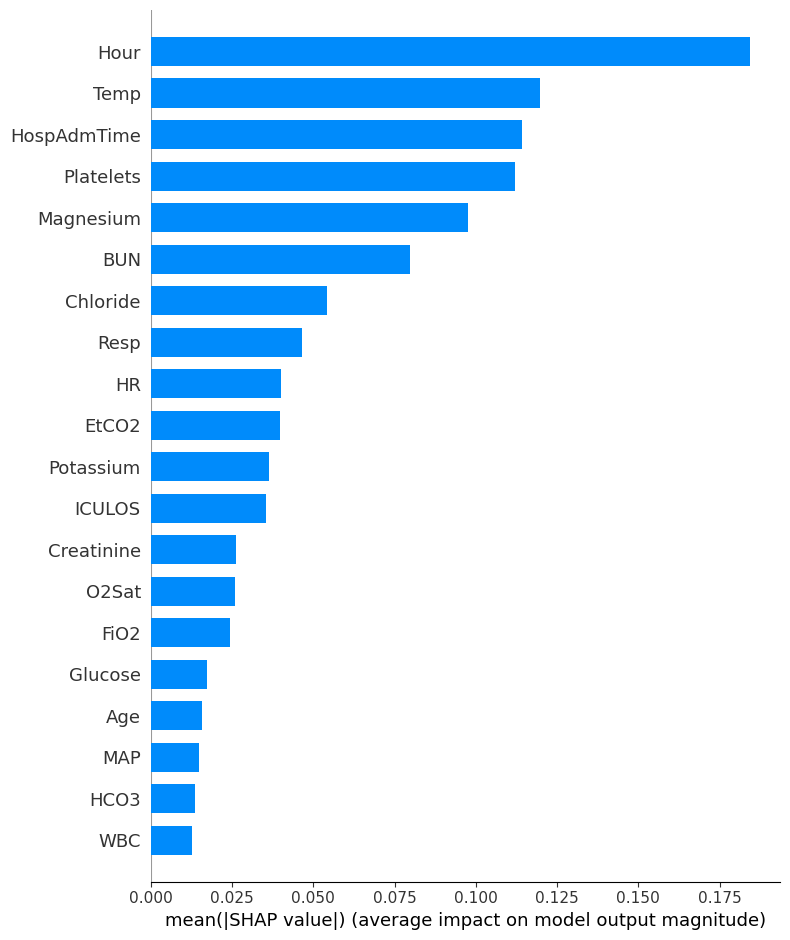

In [158]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_2, X_train, X_test)

In [161]:
X_train.describe()

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets
count,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,...,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000,197945.000000
mean,2033.847240,62.999310,0.612503,-80.164959,49.667160,47.523984,87.940924,97.245232,37.068199,121.687714,...,3.594303,4.141245,2.074628,9.072874,30.284298,10.194729,37.571407,12.508399,305.642159,183.233614
std,1130.877377,15.598421,0.487180,281.892422,51.431252,51.601876,17.491780,3.372248,0.819405,23.294101,...,1.386878,0.566385,4.172896,14.597728,4.810167,1.675121,21.061178,6.484373,168.727859,103.520948
min,0.000000,18.000000,0.000000,-5366.860000,1.000000,0.000000,20.000000,20.000000,20.900000,22.000000,...,0.300000,1.700000,0.100000,0.010000,5.500000,3.000000,12.500000,0.100000,35.000000,2.000000
25%,1048.000000,53.930000,0.000000,-68.870000,15.000000,12.000000,76.000000,96.000000,36.580000,105.000000,...,2.700000,3.778571,0.500000,0.450000,26.972000,9.036364,28.100000,8.725000,196.000000,112.600000
50%,2101.000000,65.420000,1.000000,-5.430000,31.000000,29.000000,87.000000,98.000000,37.100000,119.000000,...,3.358333,4.081818,0.900000,1.900000,29.800000,10.066667,31.600000,11.587500,260.000000,163.000000
75%,3053.000000,74.500000,1.000000,-0.030000,65.000000,63.000000,99.000000,100.000000,37.600000,136.000000,...,4.200000,4.433333,1.766667,15.500000,33.104000,11.200000,38.233333,15.075000,371.000000,229.285714
max,3828.000000,100.000000,1.000000,16.020000,336.000000,335.000000,223.000000,100.000000,42.220000,299.000000,...,16.900000,11.500000,45.900000,226.780000,60.500000,23.400000,250.000000,224.900000,1383.000000,1081.000000


In [166]:
# test sur les patients déjà atteints

admitted_with_sepsis_df['Patient_ID'] = admitted_with_sepsis_df['Patient_ID'].astype(int)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\498876949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admitted_with_sepsis_df['Patient_ID'] = admitted_with_sepsis_df['Patient_ID'].astype(int)


In [167]:
admitted_with_sepsis_df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
2212,56,68.2,1,-140.06,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2213,56,68.2,1,-140.06,2,1,86.0,100.0,36.39,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2214,56,68.2,1,-140.06,3,2,86.0,97.0,36.89,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2215,56,68.2,1,-140.06,4,3,84.0,96.5,36.56,141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2216,56,68.2,1,-140.06,5,4,85.0,97.0,NaN,147.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547049,119872,34.0,1,-0.07,4,3,94.0,95.5,NaN,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1547050,119872,34.0,1,-0.07,5,4,58.0,100.0,NaN,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1547051,119872,34.0,1,-0.07,6,5,63.5,100.0,NaN,112.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1547052,119872,34.0,1,-0.07,7,6,76.0,100.0,36.90,186.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [168]:
# Utiliser ffill et bfill pour les valeurs manquantes restantes
admitted_with_sepsis_df.fillna(method='ffill', inplace=True)


C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\4086900209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admitted_with_sepsis_df.fillna(method='ffill', inplace=True)


In [169]:
admitted_with_sepsis_df.isna().sum()

Patient_ID                 0
Age                        0
Gender                     0
HospAdmTime                0
ICULOS                     0
Hour                       0
HR                         1
O2Sat                      1
Temp                       1
SBP                        1
MAP                        1
DBP                        1
Resp                       1
EtCO2                   1781
BaseExcess                26
HCO3                       6
FiO2                       6
pH                        26
PaCO2                     26
SaO2                      26
AST                       33
BUN                        6
Alkalinephos              33
Calcium                    6
Chloride                   6
Creatinine                 6
Bilirubin_direct         269
Glucose                    6
Lactate                   26
Magnesium                  6
Phosphate                  6
Potassium                  6
Bilirubin_total           33
TroponinI               1812
Hct           

In [170]:
admitted_with_sepsis_df.fillna(method='bfill', inplace=True)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2069340426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admitted_with_sepsis_df.fillna(method='bfill', inplace=True)


In [171]:
admitted_with_sepsis_df.isna().sum()

Patient_ID              0
Age                     0
Gender                  0
HospAdmTime             0
ICULOS                  0
Hour                    0
HR                      0
O2Sat                   0
Temp                    0
SBP                     0
MAP                     0
DBP                     0
Resp                    0
EtCO2                   0
BaseExcess              0
HCO3                    0
FiO2                    0
pH                      0
PaCO2                   0
SaO2                    0
AST                     0
BUN                     0
Alkalinephos            0
Calcium                 0
Chloride                0
Creatinine              0
Bilirubin_direct        0
Glucose                 0
Lactate                 0
Magnesium               0
Phosphate               0
Potassium               0
Bilirubin_total         0
TroponinI               0
Hct                     0
Hgb                     0
PTT                     0
WBC                     0
Fibrinogen  

In [172]:
admitted_with_sepsis_df.drop(columns=['Unit1', 'Unit2', 'SepsisLabel'], inplace=True)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\307337399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admitted_with_sepsis_df.drop(columns=['Unit1', 'Unit2', 'SepsisLabel'], inplace=True)


In [173]:
X = admitted_with_sepsis_df.drop(columns='SepsisLabel_Previous')
y = admitted_with_sepsis_df['SepsisLabel_Previous']

In [174]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model_2, X, y)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    3646.0

    accuracy                           0.00    3646.0
   macro avg       0.00      0.00      0.00    3646.0
weighted avg       0.00      0.00      0.00    3646.0



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_cla

In [180]:
y_predicted = xgbc_model.predict(X)

In [189]:
print(np.unique(y_predicted, return_counts=True))


(array([0, 1]), array([ 278, 3368], dtype=int64))


In [190]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X, y)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96      3646

    accuracy                           0.92      3646
   macro avg       0.50      0.46      0.48      3646
weighted avg       1.00      0.92      0.96      3646



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# max depth augmented

In [194]:
X_train_without_id = X_train.drop(columns='Patient_ID')
X_test_without_id = X_test.drop(columns='Patient_ID')

In [196]:
y_train_without_id = y_train
y_test_without_id = y_test

In [197]:
# Calcule des meilleurs hyperparamètres
best_params_3, study_3 = perform_hyperparameter_optimization(X_train_without_id, y_train_without_id, objective, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_3)
study_filename = 'optuna_study_3_0108.pkl'
save_study(study_3, study_filename)

[I 2024-08-01 23:56:31,518] A new study created in memory with name: no-name-6eef5c4b-e09d-4dc4-b5f5-ef6152e0e4b3
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-08-02 00:03:38,707] Trial 6 finished with value: 0.7546236062846889 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 7, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 1 with value: 0.8106745965258845.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:20

[I 2024-08-02 00:13:41,033] Trial 13 finished with value: 0.806254162955037 and parameters: {'learning_rate': 0.17038577457261214, 'max_depth': 18, 'n_estimators': 133, 'min_child_weight': 4, 'gamma': 3.8606040748521204, 'subsample': 0.6971108578814278}. Best is trial 11 with value: 0.8256535372242588.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:

[I 2024-08-02 00:20:34,213] Trial 20 finished with value: 0.8449922960457182 and parameters: {'learning_rate': 0.010459916871667509, 'max_depth': 5, 'n_estimators': 149, 'min_child_weight': 1, 'gamma': 4.35443372574818, 'subsample': 0.4006760004754224}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:2

[I 2024-08-02 00:26:24,547] Trial 27 finished with value: 0.7074184523498526 and parameters: {'learning_rate': 0.3560184204129349, 'max_depth': 23, 'n_estimators': 220, 'min_child_weight': 3, 'gamma': 3.4636898075282287, 'subsample': 0.016815751202712156}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.p

[I 2024-08-02 00:34:34,654] Trial 34 finished with value: 0.8409153965821055 and parameters: {'learning_rate': 0.014197323845946762, 'max_depth': 22, 'n_estimators': 163, 'min_child_weight': 2, 'gamma': 3.3292214008354732, 'subsample': 0.07268307034047794}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.

[I 2024-08-02 00:41:05,794] Trial 41 finished with value: 0.8430472963202585 and parameters: {'learning_rate': 0.010953769314751323, 'max_depth': 11, 'n_estimators': 88, 'min_child_weight': 1, 'gamma': 3.6366770755500744, 'subsample': 0.5956332231571452}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py

[I 2024-08-02 00:44:33,589] Trial 48 finished with value: 0.8430675034942917 and parameters: {'learning_rate': 0.01685653522274568, 'max_depth': 13, 'n_estimators': 62, 'min_child_weight': 3, 'gamma': 4.878070764394176, 'subsample': 0.3541899461767967}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:2

[I 2024-08-02 00:49:54,246] Trial 55 finished with value: 0.8351208337285986 and parameters: {'learning_rate': 0.010976698739036658, 'max_depth': 11, 'n_estimators': 250, 'min_child_weight': 3, 'gamma': 4.535003981547116, 'subsample': 0.26524539989161633}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.p

[I 2024-08-02 00:54:18,722] Trial 62 finished with value: 0.8256636367021655 and parameters: {'learning_rate': 0.04928210420875691, 'max_depth': 8, 'n_estimators': 102, 'min_child_weight': 3, 'gamma': 4.809901051685891, 'subsample': 0.37039288077557525}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:

[I 2024-08-02 00:58:16,374] Trial 69 finished with value: 0.7189925476468847 and parameters: {'learning_rate': 0.6589913117540606, 'max_depth': 6, 'n_estimators': 106, 'min_child_weight': 3, 'gamma': 4.356306678344474, 'subsample': 0.4993555965190582}. Best is trial 20 with value: 0.8449922960457182.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:20

[I 2024-08-02 01:00:46,209] Trial 76 finished with value: 0.8456591477959922 and parameters: {'learning_rate': 0.010553996028911605, 'max_depth': 6, 'n_estimators': 64, 'min_child_weight': 3, 'gamma': 4.603742616181632, 'subsample': 0.4649422930603447}. Best is trial 76 with value: 0.8456591477959922.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:2

[I 2024-08-02 01:02:37,812] Trial 83 finished with value: 0.8374245625143338 and parameters: {'learning_rate': 0.06687291356241161, 'max_depth': 5, 'n_estimators': 81, 'min_child_weight': 3, 'gamma': 4.32691858990418, 'subsample': 0.3805082084419456}. Best is trial 76 with value: 0.8456591477959922.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:20:

[I 2024-08-02 01:04:46,945] Trial 90 finished with value: 0.8395918154275545 and parameters: {'learning_rate': 0.057911303738398895, 'max_depth': 5, 'n_estimators': 73, 'min_child_weight': 5, 'gamma': 3.861486411405675, 'subsample': 0.29912547159406777}. Best is trial 76 with value: 0.8456591477959922.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:

[I 2024-08-02 01:06:19,344] Trial 97 finished with value: 0.8376619695640353 and parameters: {'learning_rate': 0.08355101287548618, 'max_depth': 5, 'n_estimators': 77, 'min_child_weight': 5, 'gamma': 4.417874992665145, 'subsample': 0.04249895415315137}. Best is trial 76 with value: 0.8456591477959922.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_14940\2031084472.py:2

Meilleurs hyperparamètres: {'learning_rate': 0.010553996028911605, 'max_depth': 6, 'n_estimators': 64, 'min_child_weight': 3, 'gamma': 4.603742616181632, 'subsample': 0.4649422930603447}


In [198]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_3_0108.joblib'
xgbc_model_3 = train_and_save_xgboost_classifier(X_train_without_id, y_train_without_id, best_params_3, model_path)

In [199]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model_3, X_test_without_id, y_test_without_id)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     40198
           1       0.00      0.00      0.00      7797

    accuracy                           0.84     47995
   macro avg       0.42      0.50      0.46     47995
weighted avg       0.70      0.84      0.76     47995



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [204]:
data_imputed[data_imputed['SepsisLabel_Previous'] == 0]

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous
0,000009,27.92,1,-0.03,1,0,117.0,99.0,36.0,116.0,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
1,000009,27.92,1,-0.03,2,1,117.0,99.0,36.0,116.0,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
2,000009,27.92,1,-0.03,3,2,117.6,99.2,36.0,116.4,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
3,000009,27.92,1,-0.03,4,3,118.2,99.4,36.0,116.8,...,3.6,1.5,23.2,31.0,9.65,40.8,3.900000,180.000000,114.000000,0
4,000009,27.92,1,-0.03,5,4,118.8,99.6,36.0,117.2,...,3.6,1.5,23.2,28.0,9.30,39.8,4.033333,190.666667,115.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245935,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245936,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245937,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245938,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0


In [207]:
data_imputed[data_imputed['Patient_ID'] == '119994'].tail()

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous
245935,119994,71.0,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,4.4,1.2,28.4,30.3,10.2,57.0,11.4,158.0,62.0,0
245936,119994,71.0,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,4.4,1.2,28.4,30.3,10.2,57.0,11.4,158.0,62.0,0
245937,119994,71.0,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,4.4,1.2,28.4,30.3,10.2,57.0,11.4,158.0,62.0,0
245938,119994,71.0,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,4.4,1.2,28.4,30.3,10.2,57.0,11.4,158.0,62.0,0
245939,119994,71.0,1,-29.57,42,41,72.0,95.5,37.6,95.0,...,4.4,1.2,28.4,30.3,10.2,57.0,11.4,158.0,62.0,0


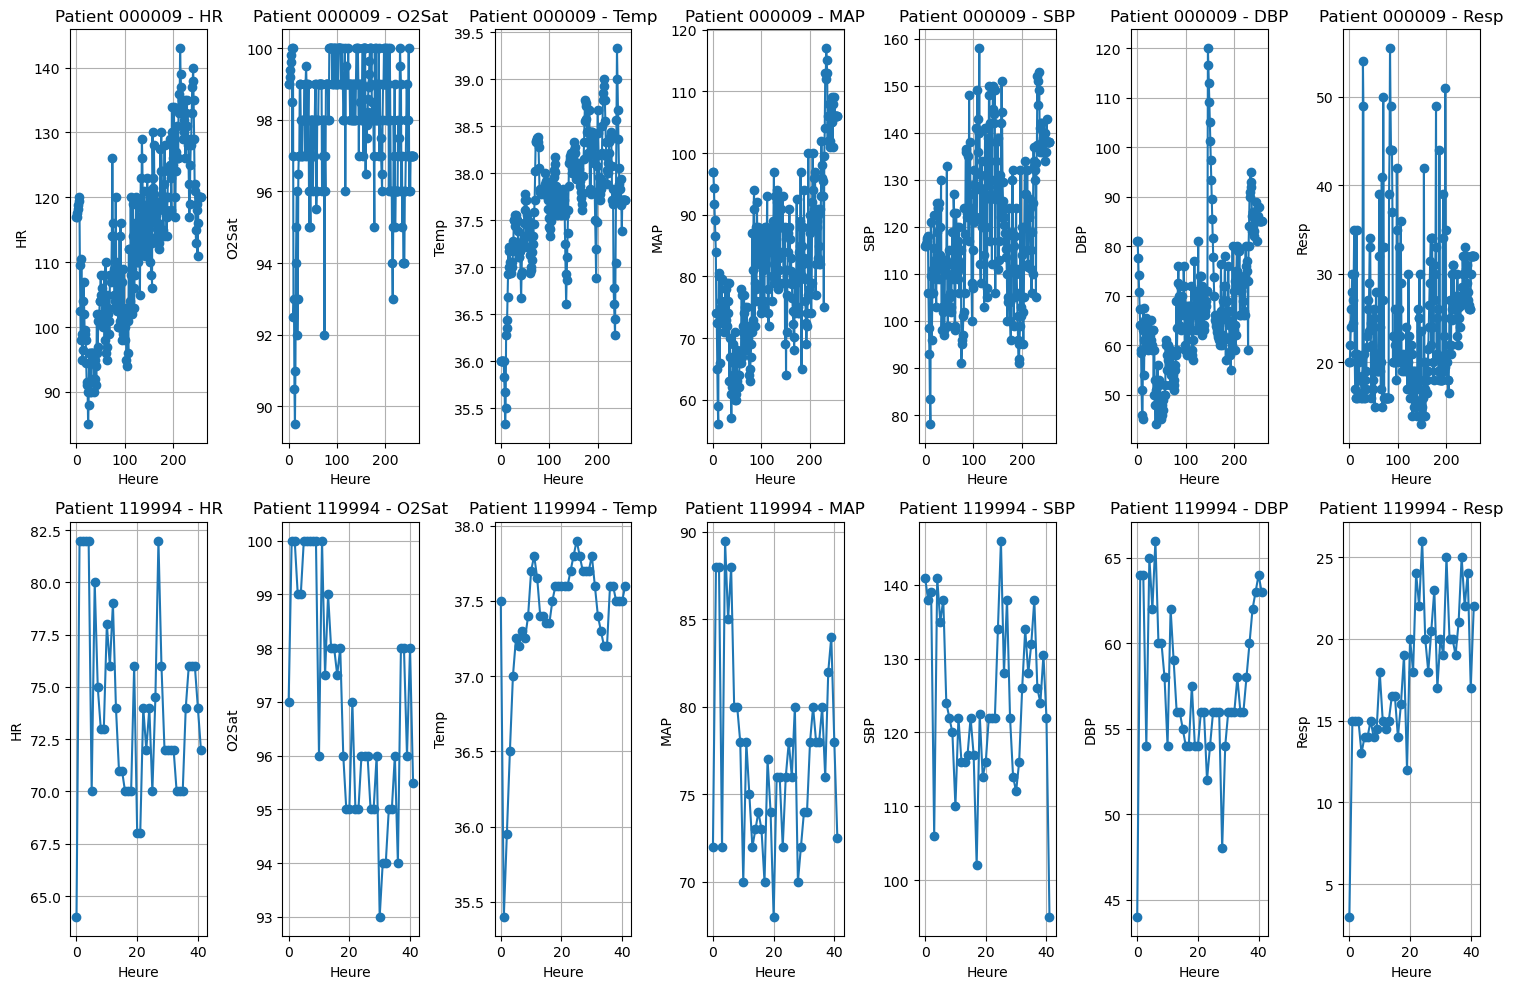

In [210]:
import matplotlib.pyplot as plt
patient_ids = ['000009', '119994']
variables = ['HR', 'O2Sat', 'Temp', 'MAP', 'SBP', 'DBP', 'Resp']

fig, axes = plt.subplots(nrows=len(patient_ids), ncols=len(variables), figsize=(15, 10))

for i, patient_id in enumerate(patient_ids):
    for j, variable in enumerate(variables):
        patient_data = data_imputed[data_imputed['Patient_ID'] == patient_id]
        axes[i, j].plot(patient_data['Hour'], patient_data[variable], marker='o', linestyle='-')
        axes[i, j].set_title(f'Patient {patient_id} - {variable}')
        axes[i, j].set_xlabel('Heure')
        axes[i, j].set_ylabel(variable)
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()


In [5]:
import matplotlib.pyplot as plt

def plot_variables_for_patients(data, patient_ids, variables):
    """
    Trace l'évolution des variables pour deux patients sur des lignes distinctes avec des couleurs différentes.

    Args:
    data (DataFrame): Le DataFrame contenant les données.
    patient_ids (list): Liste contenant les identifiants des deux patients.
    variables (list): Liste des variables à tracer.
    """
    # Définir les couleurs pour les deux patients
    colors = ['blue', 'green']
    
    # Créer une figure avec un sous-graphique pour chaque variable sur des lignes distinctes
    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, 6 * len(variables)))  # Ajuster la taille globale de la figure
    
    # Si une seule variable est tracée, axes n'est pas un array
    if len(variables) == 1:
        axes = [axes]
    
    # Boucler sur chaque variable
    for i, var in enumerate(variables):
        for j, patient_id in enumerate(patient_ids):
            # Filtrer les données pour le patient et la variable actuelle
            patient_data = data[data['Patient_ID'] == patient_id]
            
            # Tracer les données sur le sous-graphique correspondant
            axes[i].plot(patient_data['Hour'], patient_data[var], marker='.', linestyle='-', color=colors[j], label=f'Patient {patient_id}')
            axes[i].set_title(f'{var} Evolution')
            axes[i].set_xlabel('Hour')
            axes[i].set_ylabel(var)
            axes[i].legend()
            axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()


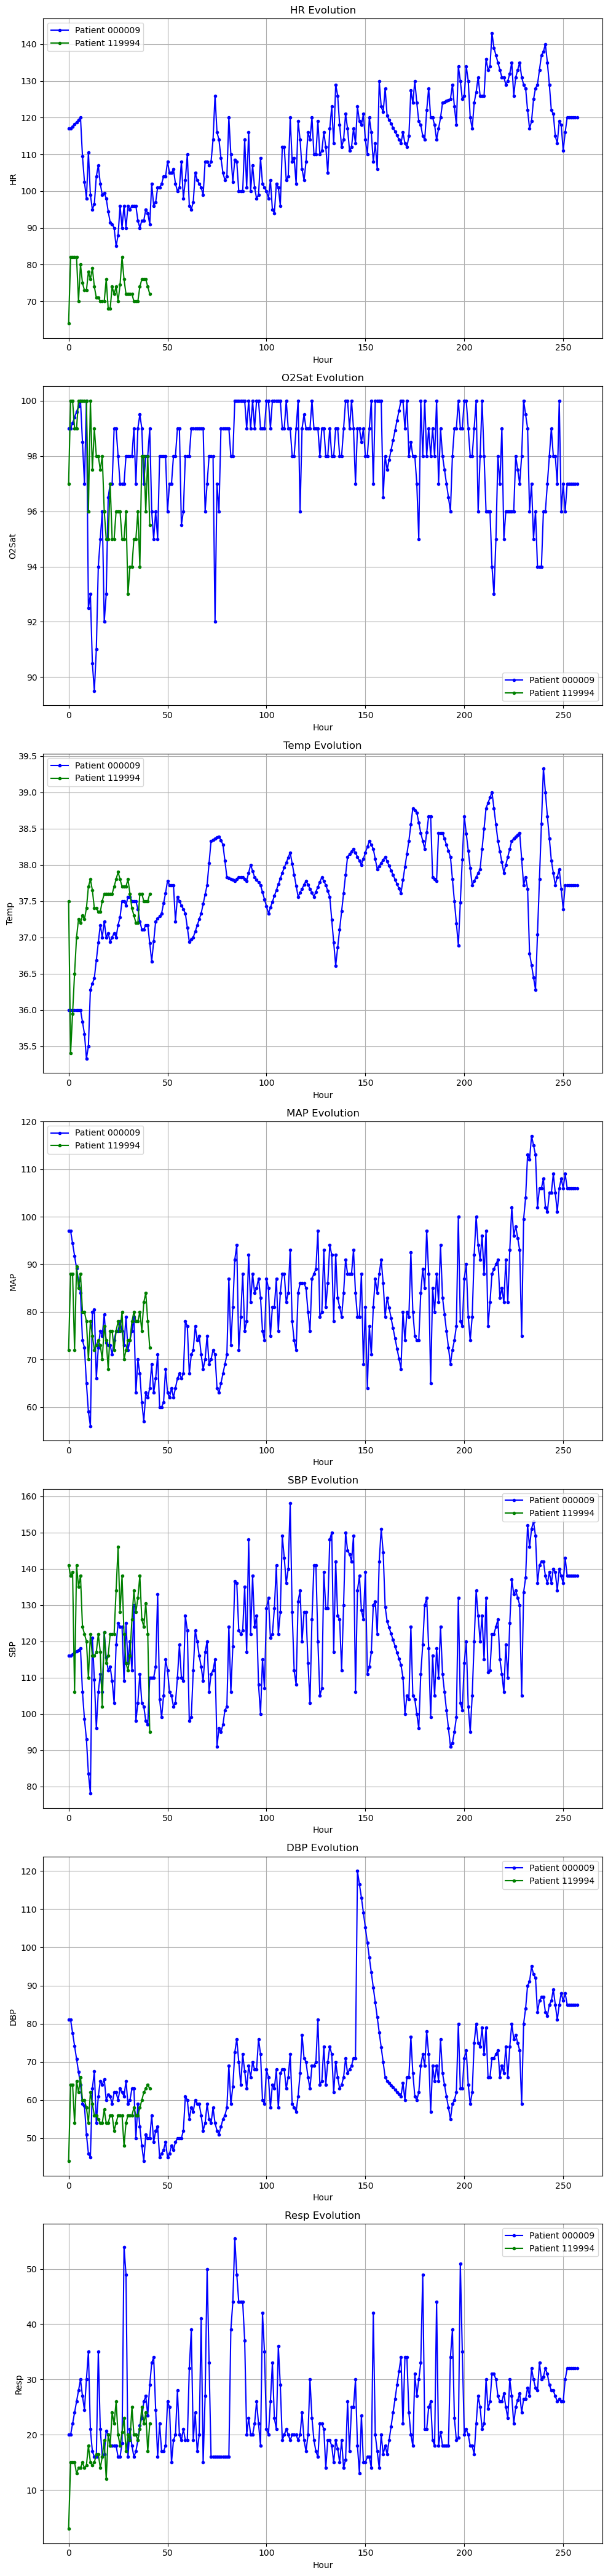

In [214]:

# Appel de la fonction avec des exemples de patients et de variables
plot_variables_for_patients(data_imputed, patient_ids, variables)


# Journée du 02/08

In [3]:
full_data = pd.read_csv('full_data_df.csv')

In [4]:
full_data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,1,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.00,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552206,120000,62.00,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552207,120000,62.00,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552208,120000,62.00,0,0.00,34,33,82.0,99.0,36.6,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [10]:
full_data[full_data['SepsisLabel'] == 0].head(20)

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,1,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,1,83.14,0,-0.03,6,5,110.0,91.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,1,83.14,0,-0.03,7,6,108.0,92.0,36.11,123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
7,1,83.14,0,-0.03,8,7,106.0,90.5,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,1,83.14,0,-0.03,9,8,104.0,95.0,NaN,133.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
9,1,83.14,0,-0.03,10,9,102.0,91.0,NaN,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


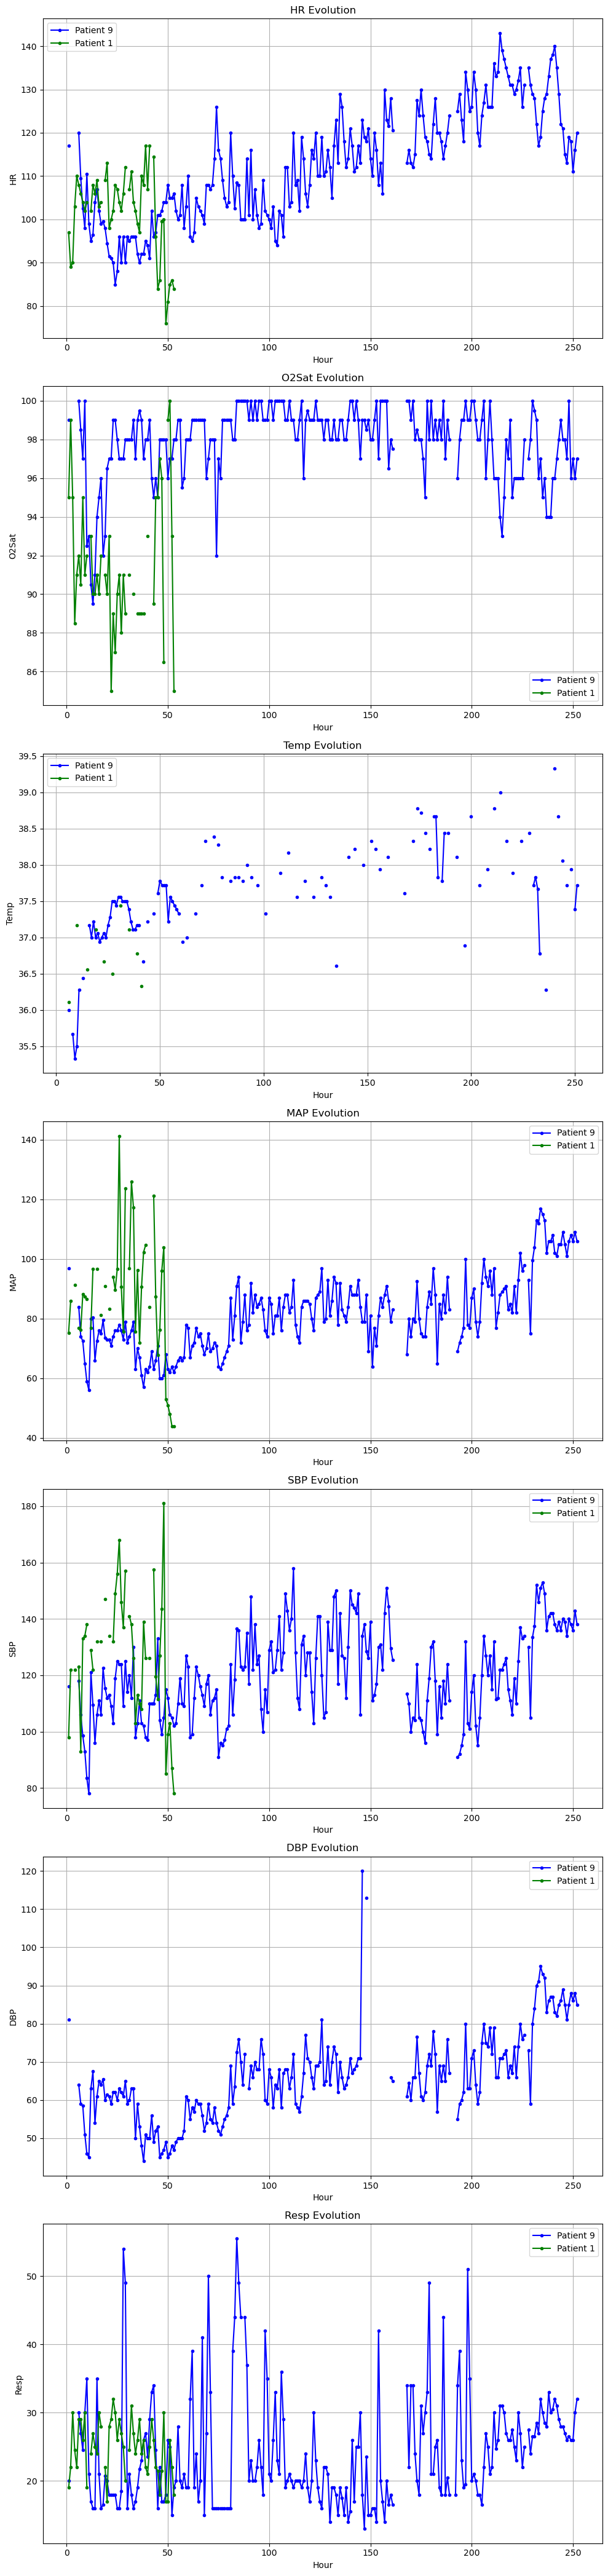

In [11]:
patient_ids = [9, 1]
variables = ['HR', 'O2Sat', 'Temp', 'MAP', 'SBP', 'DBP', 'Resp']

plot_variables_for_patients(full_data, patient_ids, variables)

In [12]:
admitted_with_sepsis_df = pd.read_csv('patient_admitted_with_sepsis.csv')

In [13]:
admitted_with_sepsis_df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,56,68.2,1,-140.06,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
1,56,68.2,1,-140.06,2,1,86.0,100.0,36.39,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
2,56,68.2,1,-140.06,3,2,86.0,97.0,36.89,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
3,56,68.2,1,-140.06,4,3,84.0,96.5,36.56,141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
4,56,68.2,1,-140.06,5,4,85.0,97.0,NaN,147.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,119872,34.0,1,-0.07,4,3,94.0,95.5,NaN,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3642,119872,34.0,1,-0.07,5,4,58.0,100.0,NaN,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3643,119872,34.0,1,-0.07,6,5,63.5,100.0,NaN,112.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3644,119872,34.0,1,-0.07,7,6,76.0,100.0,36.90,186.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [18]:
admitted_with_sepsis_patients = admitted_with_sepsis_df['Patient_ID'].unique()
len(admitted_with_sepsis_patients)

426

In [19]:
# Filtrer full_data pour exclure les patients présents dans admitted_with_sepsis_df
remaining_data = full_data[~full_data['Patient_ID'].isin(admitted_with_sepsis_patients)]
remaining_data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,1,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.00,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552206,120000,62.00,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552207,120000,62.00,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552208,120000,62.00,0,0.00,34,33,82.0,99.0,36.6,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [20]:
balanced_data, controle_df = balance_classes_by_missing_data(remaining_data)
balanced_data.shape

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_27184\1890833736.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['missing_count'] = full_df.isnull().sum(axis=1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_27184\1890833736.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns='missing_count', inplace=True)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_27184\1890833736.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

(245940, 44)

In [21]:
controle_df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,1,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.00,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552206,120000,62.00,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552207,120000,62.00,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1552208,120000,62.00,0,0.00,34,33,82.0,99.0,36.6,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [22]:
controle_with_sepsis_before_adm = pd.concat([remaining_data, controle_df])
controle_with_sepsis_before_adm

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous,missing_count
0,1,83.14,0,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,36.0
1,1,83.14,0,-0.03,2,1,97.0,95.0,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,31.0
2,1,83.14,0,-0.03,3,2,89.0,99.0,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,31.0
3,1,83.14,0,-0.03,4,3,90.0,95.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,30.0
4,1,83.14,0,-0.03,5,4,103.0,88.5,NaN,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,120000,62.00,0,0.00,31,30,80.0,96.0,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1552206,120000,62.00,0,0.00,32,31,74.0,97.0,NaN,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1552207,120000,62.00,0,0.00,33,32,78.0,98.0,NaN,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1552208,120000,62.00,0,0.00,34,33,82.0,99.0,36.6,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [23]:
from sklearn.utils import shuffle

def balance_classes_by_missing_data(full_df, label_column='SepsisLabel_Previous', patient_id_column='Patient_ID', test_size=0.2, random_state=42):
    """
    Équilibre les classes en sous-échantillonnant la classe majoritaire basé sur la complétude des données,
    tout en préservant la temporalité des enregistrements pour chaque patient.
    
    Parameters:
    - full_df (pandas.DataFrame): DataFrame contenant les données des patients.
    - label_column (str): Nom de la colonne contenant les labels de classification.
    - patient_id_column (str): Nom de la colonne contenant les identifiants des patients.
    - test_size (float): Proportion de l'ensemble de test par rapport à l'ensemble total.
    - random_state (int): Graine pour la reproductibilité des résultats aléatoires.

    Returns:
    - X_train (pandas.DataFrame): Caractéristiques pour l'entraînement.
    - X_test (pandas.DataFrame): Caractéristiques pour le test.
    - y_train (pandas.Series): Labels pour l'entraînement.
    - y_test (pandas.Series): Labels pour le test.
    """
    # Calculer le nombre de valeurs manquantes pour chaque patient
    full_df['missing_count'] = full_df.isnull().sum(axis=1)
    missing_by_patient = full_df.groupby(patient_id_column)['missing_count'].mean().sort_values()

    # Sélectionner les patients de la classe minoritaire et majoritaire
    patients_minority = full_df[full_df[label_column] == 1][patient_id_column].unique()
    patients_majority = full_df[full_df[label_column] == 0][patient_id_column].unique()

    # Déterminer le nombre de patients à sélectionner dans la classe majoritaire
    n_samples = min(len(patients_minority), len(patients_majority))

    # Sélectionner les patients avec le moins de valeurs manquantes dans la classe majoritaire
    selected_majority = missing_by_patient[missing_by_patient.index.isin(patients_majority)].head(n_samples).index

    # Sélectionner les données des patients choisis
    selected_patients = np.concatenate([selected_majority, patients_minority])

    # Mélanger seulement les identifiants des patients pour préserver la temporalité
    np.random.shuffle(selected_patients)

    # Filtrer le DataFrame pour les patients sélectionnés et diviser en ensembles de train et test
    filtered_df = full_df[full_df[patient_id_column].isin(selected_patients)]
    filtered_df.drop(columns='missing_count', inplace=True)
    

    
    return filtered_df


In [24]:
controle_with_sepsis_before_adm_df = balance_classes_by_missing_data(controle_with_sepsis_before_adm)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_27184\2942561727.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns='missing_count', inplace=True)


In [25]:
controle_with_sepsis_before_adm_df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
304,9,27.92,1,-0.03,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
305,9,27.92,1,-0.03,2,1,117.0,99.0,NaN,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
306,9,27.92,1,-0.03,3,2,NaN,NaN,NaN,NaN,...,37.6,12.70,46.4,8.9,124.0,64.0,NaN,NaN,0,0
307,9,27.92,1,-0.03,4,3,NaN,NaN,NaN,NaN,...,31.0,9.65,40.8,3.9,180.0,114.0,NaN,NaN,0,0
308,9,27.92,1,-0.03,5,4,NaN,NaN,NaN,NaN,...,28.0,9.30,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551986,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0
1551987,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0
1551988,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0
1551989,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0


In [26]:
controle_with_sepsis_before_adm_df['SepsisLabel'].value_counts()

SepsisLabel
0    221670
1     24270
Name: count, dtype: int64

In [27]:
balanced_data.isna().sum().sum()

6508338

In [31]:
controle_with_sepsis_before_adm_df.isna().sum().sum()

6508338

In [28]:
# Appliquer d'abord une interpolation linéaire
data_imputed = balanced_data.groupby('Patient_ID').apply(lambda group: group.interpolate(method='linear'))

data_imputed_controle = controle_with_sepsis_before_adm_df.groupby('Patient_ID').apply(lambda group: group.interpolate(method='linear'))

In [29]:
data_imputed.isna().sum().sum()

2511377

In [30]:
data_imputed_controle.isna().sum().sum()

2511377

In [36]:
data_imputed = data_imputed.reset_index(drop=True)
data_imputed_controle = data_imputed.reset_index(drop=True)

In [42]:
# Utiliser ffill et bfill pour les valeurs manquantes restantes
data_imputed.fillna(method='ffill', inplace=True)
data_imputed.fillna(method='bfill', inplace=True)

In [43]:
data_imputed.isna().sum().sum()

0

In [44]:
# Utiliser ffill et bfill pour les valeurs manquantes restantes
data_imputed_controle.fillna(method='ffill', inplace=True)
data_imputed_controle.fillna(method='bfill', inplace=True)

In [45]:
data_imputed_controle.isna().sum().sum()

0

In [47]:
# data_imputed.to_csv('training_df_0208.csv', index=False)
# data_imputed_controle.to_csv('controle_training_df_0208.csv', index=False)

In [51]:
# data_imputed = pd.read_csv('training_df_0208.csv')
# data_imputed_controle = pd.read_csv('controle_training_df_0208.csv')

In [52]:
data_imputed.drop(columns=['Unit1', 'Unit2', 'SepsisLabel_Previous'], inplace=True)
data_imputed_controle.drop(columns=['Unit1', 'Unit2', 'SepsisLabel_Previous'], inplace=True)

In [53]:
data_imputed

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel
0,9,27.92,1,-0.03,1,0,117.0,99.0,36.0,116.0,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
1,9,27.92,1,-0.03,2,1,117.0,99.0,36.0,116.0,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
2,9,27.92,1,-0.03,3,2,117.6,99.2,36.0,116.4,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
3,9,27.92,1,-0.03,4,3,118.2,99.4,36.0,116.8,...,3.6,1.5,23.2,31.0,9.65,40.8,3.900000,180.000000,114.000000,0
4,9,27.92,1,-0.03,5,4,118.8,99.6,36.0,117.2,...,3.6,1.5,23.2,28.0,9.30,39.8,4.033333,190.666667,115.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245935,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245936,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245937,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245938,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0


# Division des données en ensembles de formation et de test par patient

In [59]:
from sklearn.model_selection import train_test_split

# Diviser les patients en ensembles d'entraînement et de test
patient_ids = data_imputed['Patient_ID'].unique()
train_patient_ids, test_patient_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

# Créer des DataFrames pour les ensembles d'entraînement et de test
train_df = data_imputed[data_imputed['Patient_ID'].isin(train_patient_ids)]
test_df = data_imputed[data_imputed['Patient_ID'].isin(test_patient_ids)]


In [ ]:
train_df.shape, test_df.shape

# Création des séquences de temps

In [64]:
# Fonction pour créer des séquences 
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for patient_id in df['Patient_ID'].unique():
        patient_data = df[df['Patient_ID'] == patient_id].drop(columns=['Patient_ID'])
        for i in range(len(patient_data) - sequence_length):
            sequence = patient_data.iloc[i:i + sequence_length].drop(columns=['SepsisLabel']).values
            label = patient_data.iloc[i + sequence_length]['SepsisLabel']
            sequences.append(sequence)
            labels.append(label)
    return np.array(sequences), np.array(labels)


In [65]:
# Créer des séquences pour les ensembles d'entraînement et de test
sequence_length = 6  # Longueur de la séquence
X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)

In [67]:
# Création des séquences pour l'ensemble de validation
X_val, y_val = create_sequences(data_imputed_controle, sequence_length)

# Normalisation des données

In [68]:
from sklearn.preprocessing import MinMaxScaler

# Apprendre le scaler sur les données d'entraînement uniquement
scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # Mise en forme pour ajuster le scaler
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled.reshape(X_train.shape)

# Appliquer le scaler aux données de test
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])  # Mise en forme pour transformer
X_test_scaled = scaler.transform(X_test_reshaped)
X_test = X_test_scaled.reshape(X_test.shape)


In [69]:
# Appliquer le scaler aux données de validation
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])  # Mise en forme pour transformer
X_val_scaled = scaler.transform(X_val_reshaped)
X_val = X_val_scaled.reshape(X_val.shape)

# Construction et entraînement du modèle LSTM

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(100, input_shape=(sequence_length, X_train.shape[2])))  # Ajustement de l'entrée
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.8946 - loss: 0.3346 - val_accuracy: 0.8824 - val_loss: 0.3594
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8960 - loss: 0.3235 - val_accuracy: 0.8824 - val_loss: 0.3651
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8971 - loss: 0.3195 - val_accuracy: 0.8824 - val_loss: 0.3602
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8972 - loss: 0.3169 - val_accuracy: 0.8824 - val_loss: 0.3627
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8962 - loss: 0.3163 - val_accuracy: 0.8813 - val_loss: 0.3602
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8969 - loss: 0.3112 - val_accuracy: 0.8799 - val_loss: 0.3698
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8969 - loss: 0.3081 - val_accuracy: 0.8777 - val_loss: 0.3708
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8975 - loss: 0

In [71]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')


1321/1321 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8799 - loss: 0.3564
Accuracy: 86.93%


In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Prédictions sur l'ensemble de test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcul des métriques
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Affichage de la matrice de confusion et du rapport de classification
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)


1321/1321 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Precision: 0.19
Recall: 0.05
F1 Score: 0.08
Confusion Matrix:
[[36477  1039]
 [ 4482   249]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     37516
         1.0       0.19      0.05      0.08      4731

    accuracy                           0.87     42247
   macro avg       0.54      0.51      0.51     42247
weighted avg       0.81      0.87      0.83     42247



In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Prédictions sur l'ensemble de test
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcul des métriques
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Affichage de la matrice de confusion et du rapport de classification
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)


6789/6789 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
Precision: 0.41
Recall: 0.07
F1 Score: 0.12
Confusion Matrix:
[[191661   2244]
 [ 21752   1561]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94    193905
         1.0       0.41      0.07      0.12     23313

    accuracy                           0.89    217218
   macro avg       0.65      0.53      0.53    217218
weighted avg       0.85      0.89      0.85    217218



In [81]:
model_prime = Sequential()
model_prime.add(LSTM(100, input_shape=(sequence_length, X_train.shape[2])))  # Ajustement de l'entrée
model_prime.add(Dense(1, activation='sigmoid'))

model_prime.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_prime.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8944 - loss: 0.3370 - val_accuracy: 0.8824 - val_loss: 0.3603
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8955 - loss: 0.3240 - val_accuracy: 0.8824 - val_loss: 0.3595
Epoch 3/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8975 - loss: 0.3185 - val_accuracy: 0.8824 - val_loss: 0.3616
Epoch 4/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8972 - loss: 0.3184 - val_accuracy: 0.8824 - val_loss: 0.3583
Epoch 5/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8960 - loss: 0.3175 - val_accuracy: 0.8824 - val_loss: 0.3610
Epoch 6/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8962 - loss: 0.3159 - val_accuracy: 0.8819 - val_loss: 0.3650
Epoch 7/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8981 - loss: 0.3090 - val_accuracy: 0.8814 - val_loss: 0.3638
Epoch 8/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8968 - loss:

In [82]:
loss, accuracy = model_prime.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')


1321/1321 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8332 - loss: 0.4516
Accuracy: 84.13%


# fonction  d'évaluation

In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model_performance(model, X_test, y_test, threshold=0.5):
    """
    Évalue les performances d'un modèle sur l'ensemble de test et affiche les métriques de performance.

    Parameters:
    model: Le modèle entraîné à évaluer.
    X_test (numpy.array): Les données de test.
    y_test (numpy.array): Les étiquettes de test.
    threshold (float): Le seuil pour la prédiction binaire. Par défaut 0.5.

    Returns:
    metrics: Un dictionnaire contenant les métriques de performance.
    """
    # Prédictions sur l'ensemble de test
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)

    # Calcul des métriques
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Affichage des métriques
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Affichage de la matrice de confusion et du rapport de classification
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print('Confusion Matrix:')
    print(conf_matrix)
    print('\nClassification Report:')
    print(class_report)
    
    # Renvoyer les métriques sous forme de dictionnaire
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
    return metrics


In [83]:
# Exemple d'utilisation de la fonction
metrics = evaluate_model_performance(model_prime, X_test, y_test, threshold=0.5)

1321/1321 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Precision: 0.16
Recall: 0.10
F1 Score: 0.12
Confusion Matrix:
[[35065  2451]
 [ 4255   476]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     37516
         1.0       0.16      0.10      0.12      4731

    accuracy                           0.84     42247
   macro avg       0.53      0.52      0.52     42247
weighted avg       0.81      0.84      0.82     42247



# modèle 2

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_and_train_model(X_train, y_train, sequence_length, epochs=10, batch_size=64, learning_rate=0.001):
    """
    Construit, compile et entraîne un modèle LSTM.

    Parameters:
    X_train (numpy.array): Les données d'entraînement.
    y_train (numpy.array): Les étiquettes d'entraînement.
    sequence_length (int): La longueur des séquences d'entrée.
    epochs (int): Nombre d'époques d'entraînement. Par défaut 10.
    batch_size (int): Taille des lots pour l'entraînement. Par défaut 64.
    learning_rate (float): Taux d'apprentissage. Par défaut 0.001.

    Returns:
    model: Le modèle LSTM entraîné.
    history: L'historique d'entraînement du modèle.
    """

    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model, history


In [85]:
# Exemple d'utilisation de la fonction
model, history = build_and_train_model(X_train, y_train, sequence_length, epochs=20, batch_size=64, learning_rate=0.001)


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.8931 - loss: 0.3361 - val_accuracy: 0.8824 - val_loss: 0.3615
Epoch 2/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.8974 - loss: 0.3212 - val_accuracy: 0.8824 - val_loss: 0.3623
Epoch 3/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.8983 - loss: 0.3173 - val_accuracy: 0.8825 - val_loss: 0.3660
Epoch 4/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.8953 - loss: 0.3226 - val_accuracy: 0.8824 - val_loss: 0.3646
Epoch 5/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.8971 - loss: 0.3168 - val_accuracy: 0.8824 - val_loss: 0.3661
Epoch 6/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.8964 - loss: 0.3157 - val_accuracy: 0.8824 - val_loss: 0.3596
Epoch 7/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.8963 - loss: 0.3122 - val_accuracy: 0.8817 - val_loss: 0.3618
Epoch 8/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.8960 -